# Data Analysis

In [10]:
import pandas as pd
from plotnine import *

In [11]:
weather_df = pd.read_csv("../data/weather_data.csv")

## Plot precipitation hours for London
- make a new df
- plot the data using plotnine and ggplot

In [12]:
london_weather_df = weather_df[weather_df['city'] == 'London']
london_precipitation_plot_df = london_weather_df.loc[:,['date', 'precipitation_hours']]

london_precipitation_plot_df['date'] = pd.to_datetime(london_precipitation_plot_df['date'])

# Aggregate the data by year and calculate the total precipitation hours for each year
london_precipitation_plot_df['year'] = london_precipitation_plot_df['date'].dt.year
london_yearly_precipitation_plot_df = london_precipitation_plot_df.groupby('year')['precipitation_hours'].sum().reset_index()

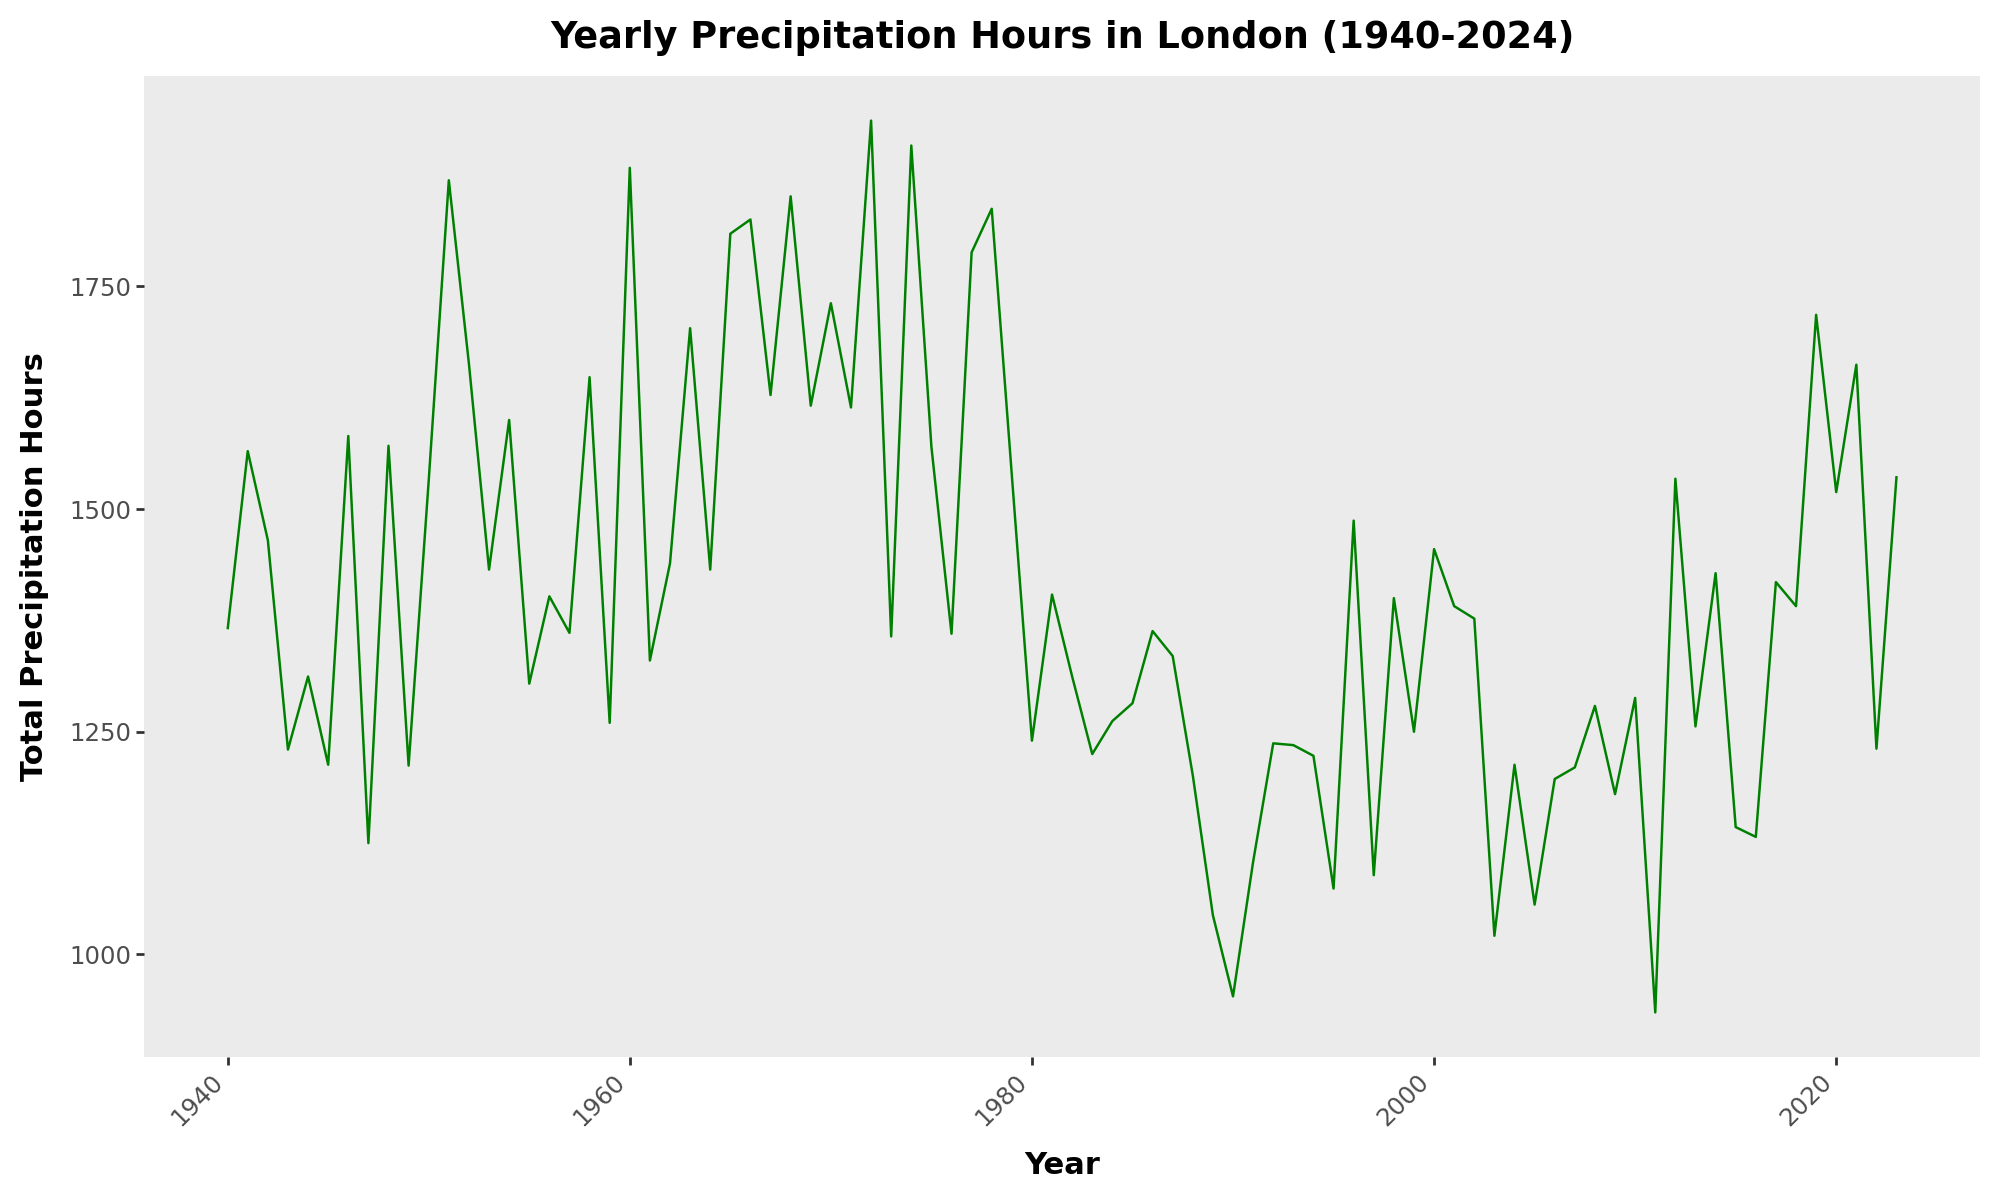

In [13]:
# Plot the aggregated data
yearly_precip_hours_plot = (ggplot(london_yearly_precipitation_plot_df) +
        aes(x='year', y='precipitation_hours') +
        geom_line(color='green') +
        labs(title='Yearly Precipitation Hours in London (1940-2024)', x='Year', y='Total Precipitation Hours') +
        theme(axis_text_x=element_text(angle=45, hjust=1),
              axis_title=element_text(weight='bold'),
              plot_title=element_text(weight='bold'),
              panel_grid=element_blank()) +
        theme(figure_size=(10, 6))  # Adjust the figure size
       )

# Displaying the plot
yearly_precip_hours_plot.show()

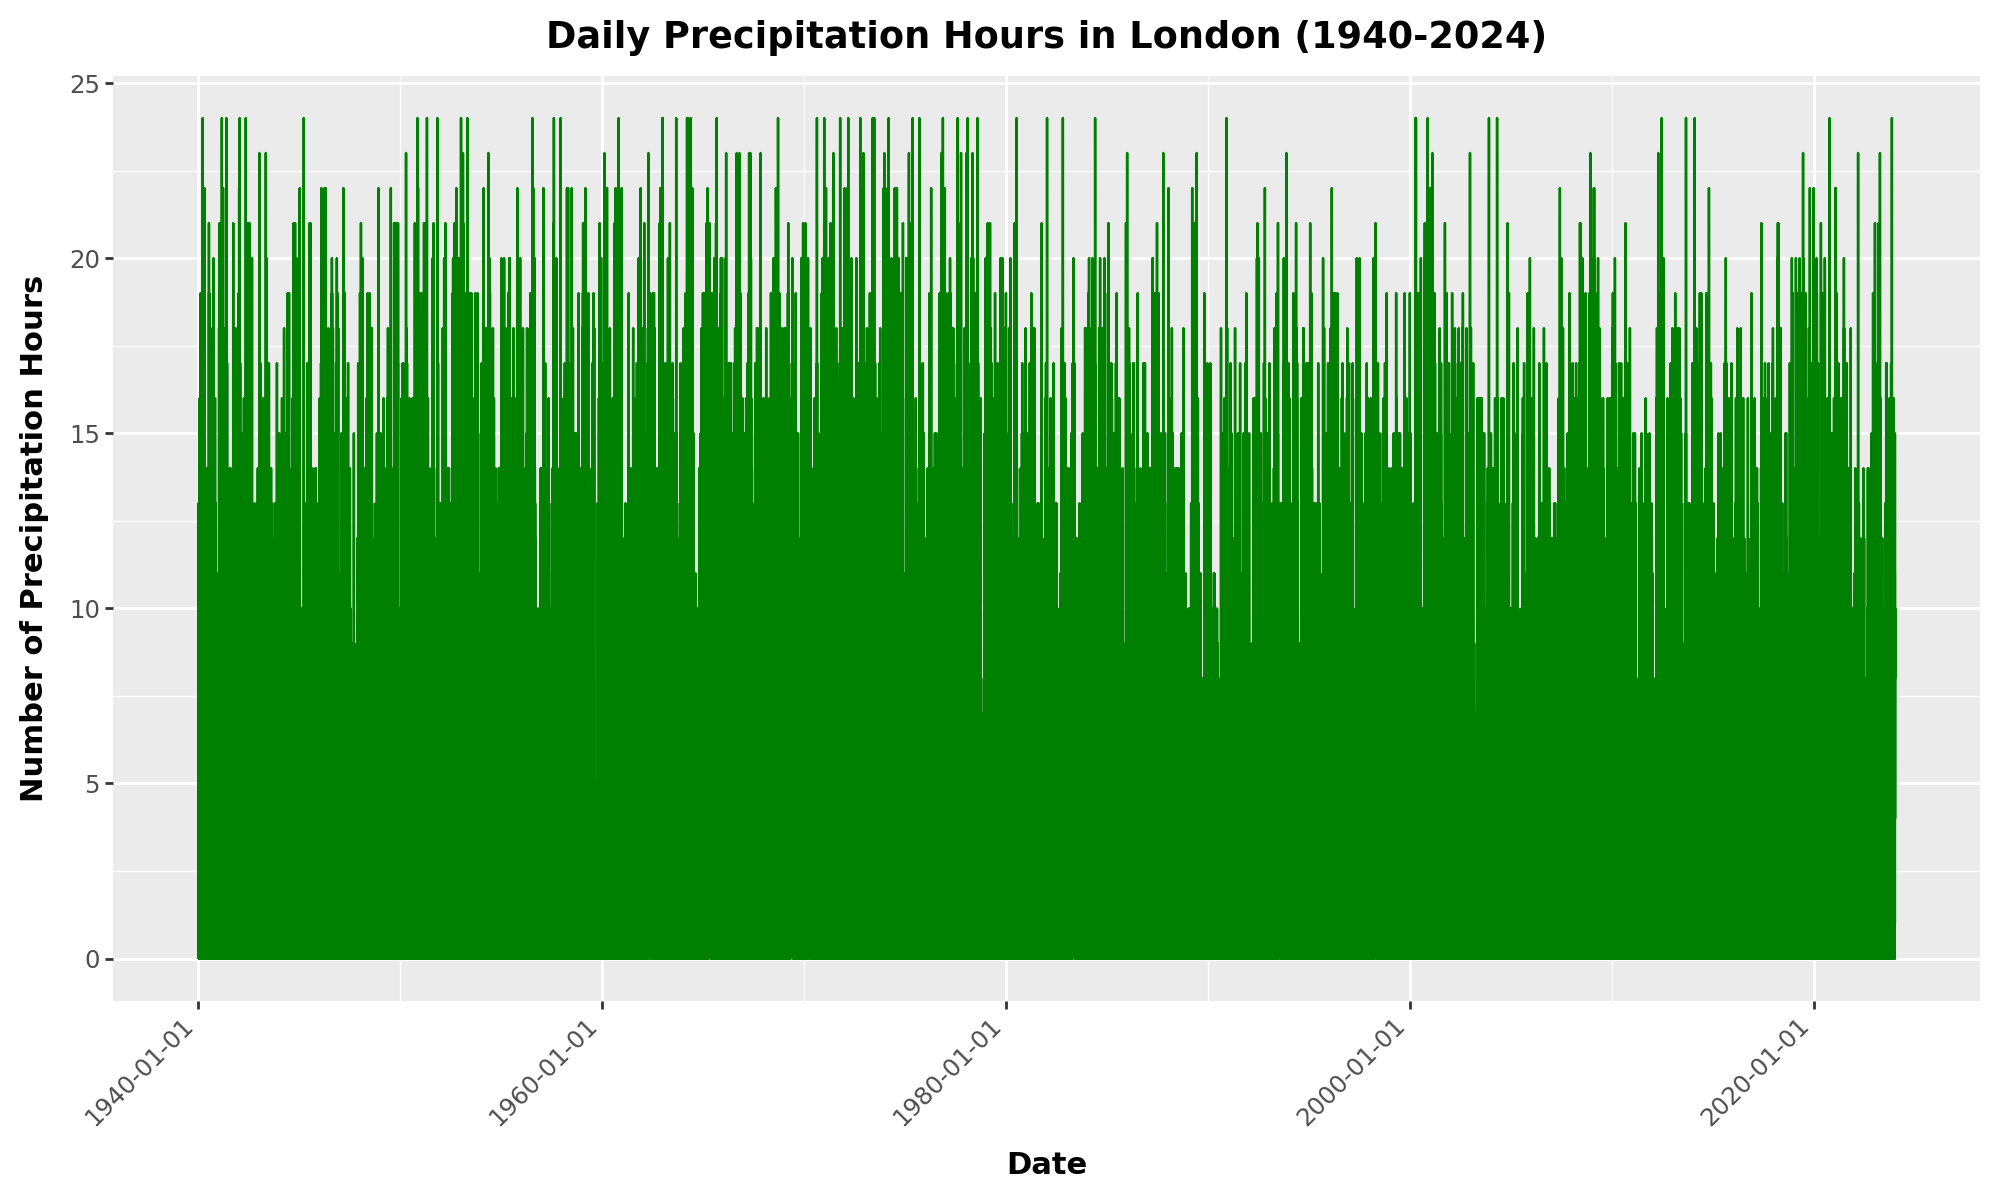

In [14]:
# Plotting aggregate data
daily_precip_hours_plot = (ggplot(london_precipitation_plot_df) +
        aes(x='date', y='precipitation_hours') +
        geom_line(color='green') +
        labs(title='Daily Precipitation Hours in London (1940-2024)', x='Date', y='Number of Precipitation Hours') +
        theme(axis_text_x=element_text(angle=45, hjust=1),
              axis_title=element_text(weight='bold'),
              plot_title=element_text(weight='bold')) +
        theme(figure_size=(10, 6)) 
       )

# Displaying the plot
daily_precip_hours_plot.show()

## Plot precipitation sum for London
- make a new df
- plot the data using plotnine and ggplot

In [15]:
# Make dataframe here

london_weather_df = weather_df[weather_df['city'] == 'London']
london_precipitation_sum_plot_df = london_weather_df.loc[:,['date', 'precipitation_sum']]

london_precipitation_sum_plot_df['date'] = pd.to_datetime(london_precipitation_sum_plot_df['date'])

# Aggregate the data by year and calculate the total precipitation hours for each year
london_precipitation_sum_plot_df['year'] = london_precipitation_sum_plot_df['date'].dt.year
london_yearly_precipitation_plot_df = london_precipitation_sum_plot_df.groupby('year')['precipitation_sum'].sum().reset_index()

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


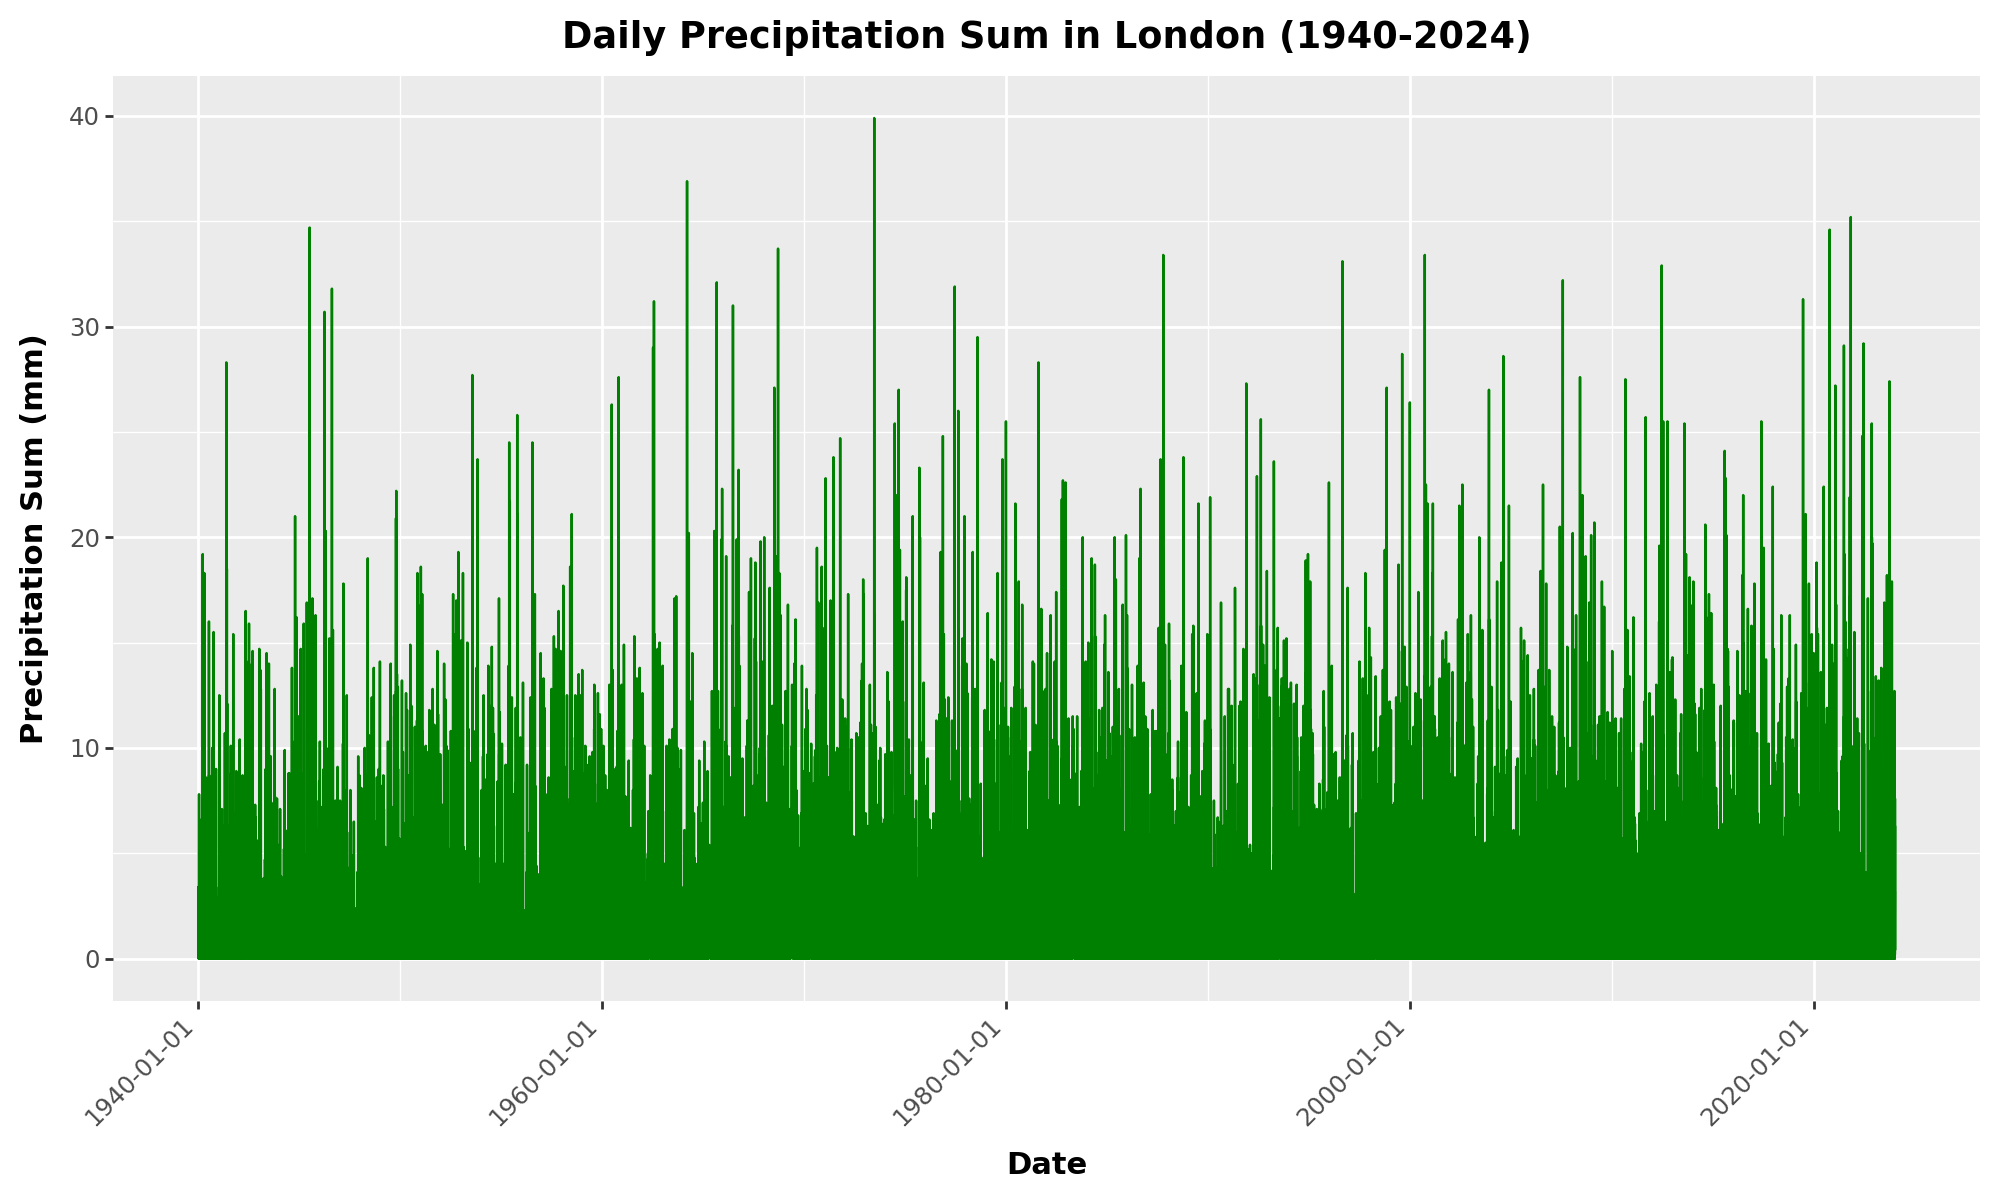

In [16]:
# Plotting the aggregated data 
daily_precip_sum_plot = (ggplot(london_precipitation_sum_plot_df) +
        aes(x='date', y='precipitation_sum') +
        geom_line(color='green') +
        labs(title='Daily Precipitation Sum in London (1940-2024)', x='Date', y='Precipitation Sum (mm)') +
        theme(axis_text_x=element_text(angle=45, hjust=1),
              axis_title=element_text(weight='bold'),
              plot_title=element_text(weight='bold')) +
        theme(figure_size=(10, 6))  
       )

# Displaying the plot
daily_precip_sum_plot.show()

In [17]:
# Make dataframe here

london_weather_df = weather_df[weather_df['city'] == 'London']
london_precipitation_sum_plot_df = london_weather_df.loc[:,['date', 'precipitation_sum']]

london_precipitation_sum_plot_df['date'] = pd.to_datetime(london_precipitation_sum_plot_df['date'])

# Aggregate the data by year and calculate the total precipitation hours for each year
london_precipitation_sum_plot_df['year'] = london_precipitation_sum_plot_df['date'].dt.year
london_yearly_precipitation_plot_df = london_precipitation_sum_plot_df.groupby('year')['precipitation_sum'].sum().reset_index()

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


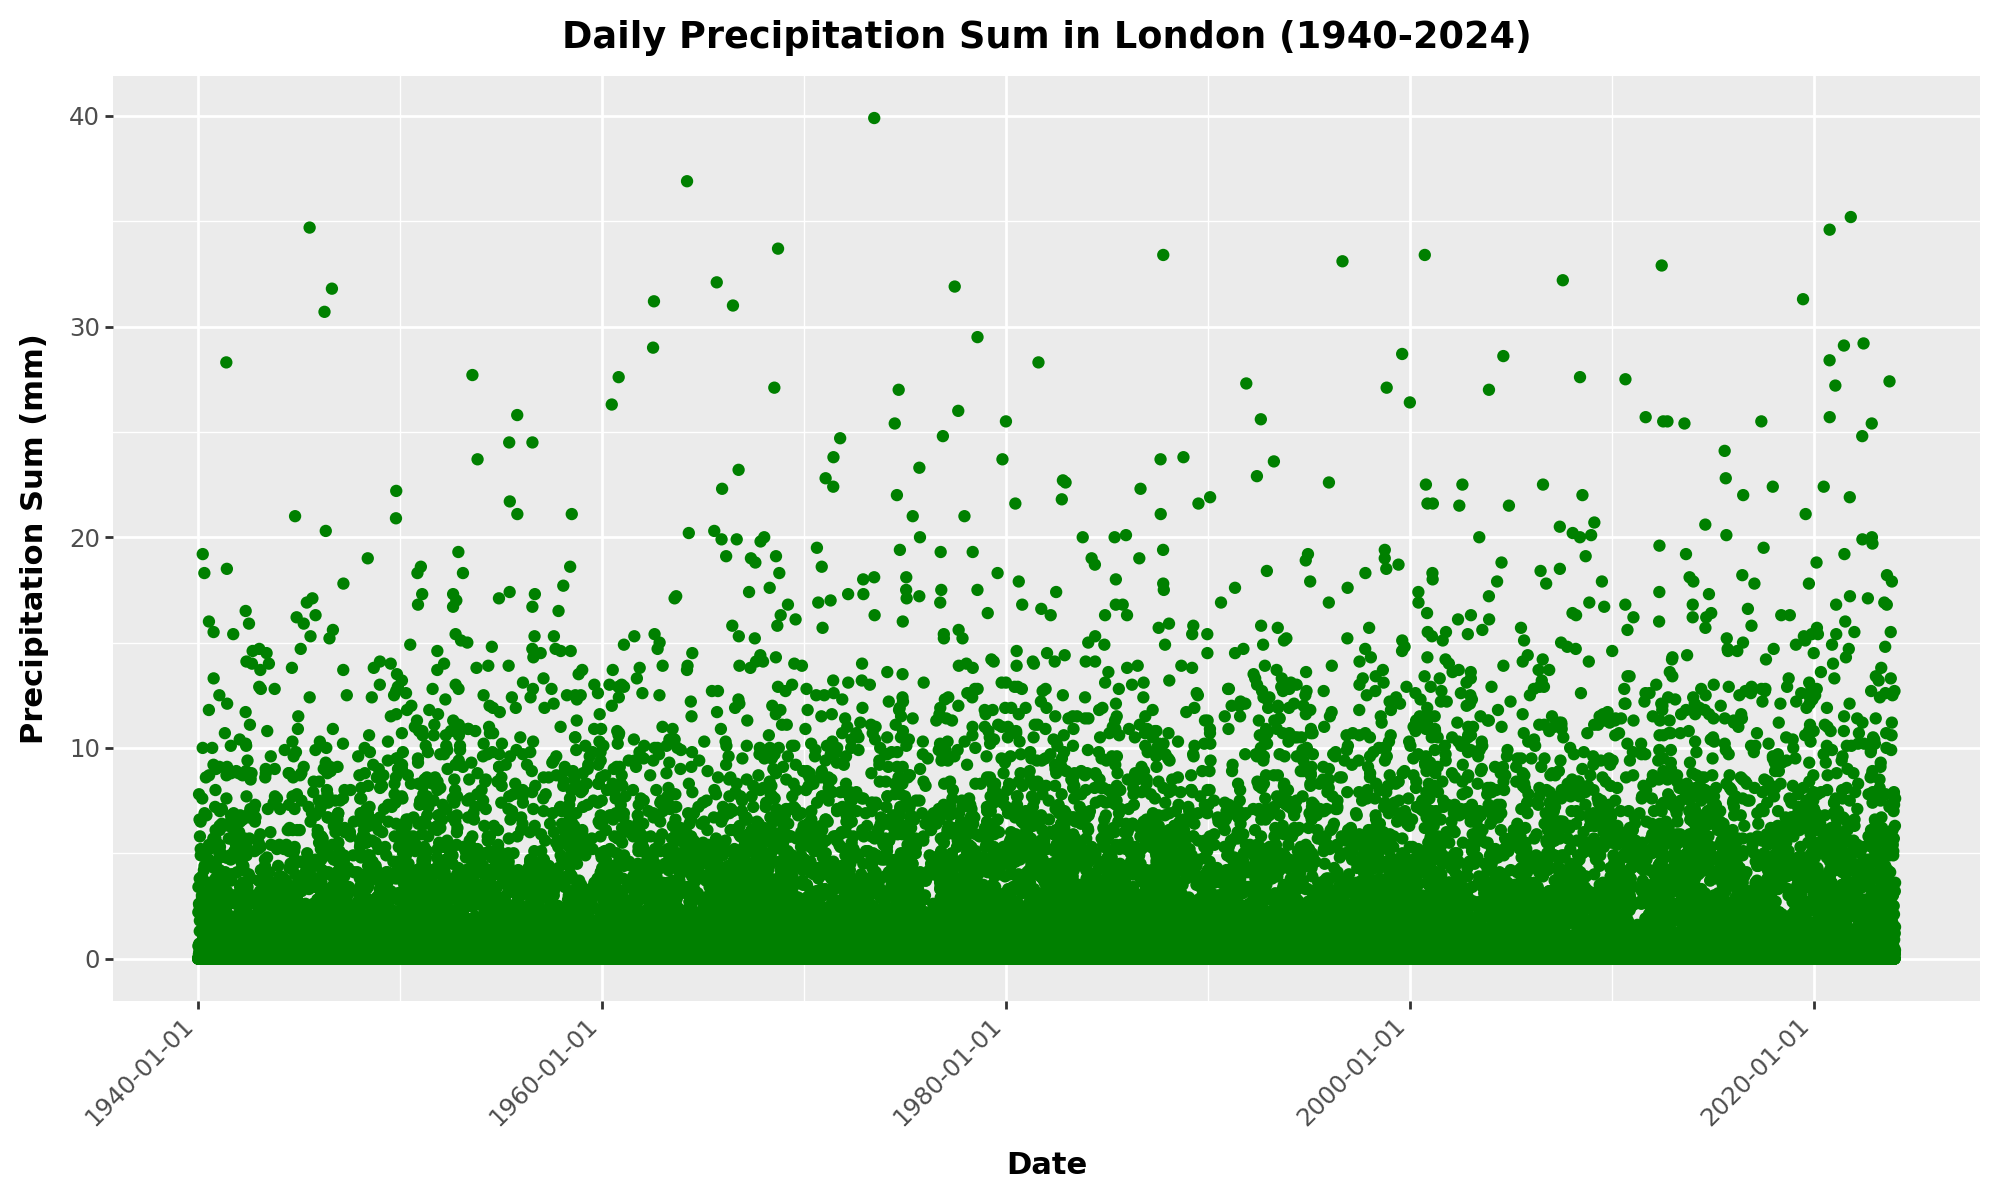

In [18]:
# Creating a plot using Plotnine with points
daily_precip_sum_dot_plot = (ggplot(london_precipitation_sum_plot_df) +
        aes(x='date', y='precipitation_sum') +
        geom_point(color='green') +  
        labs(title='Daily Precipitation Sum in London (1940-2024)', x='Date', y='Precipitation Sum (mm)') +
        theme(axis_text_x=element_text(angle=45, hjust=1),
              axis_title=element_text(weight='bold'),
              plot_title=element_text(weight='bold')) +
        theme(figure_size=(10, 6)) 
       )

# Displaying the plot
daily_precip_sum_dot_plot.show()

## Plot rainy days for London
- make a new df
- plot the data using plotnine and ggplot

In [19]:
london_rainy_days_df = london_weather_df.loc[:, ['date', 'precipitation_hours']]
london_rainy_days_df['rainy_day'] = (london_rainy_days_df['precipitation_hours'] > 0).astype(int)
london_rainy_days_df = london_rainy_days_df[['date', 'rainy_day']]

london_rainy_days_df

,date,rainy_day
61362,1940-01-01,0
61363,1940-01-02,0
61364,1940-01-03,0
61365,1940-01-04,0
61366,1940-01-05,0
...,...,...
92038,2023-12-27,1
92039,2023-12-28,1
92040,2023-12-29,1
92041,2023-12-30,1


/var/folders/6w/w0l0jj416lb8x18v4b5chr800000gn/T/ipykernel_70426/1274029619.py:26: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


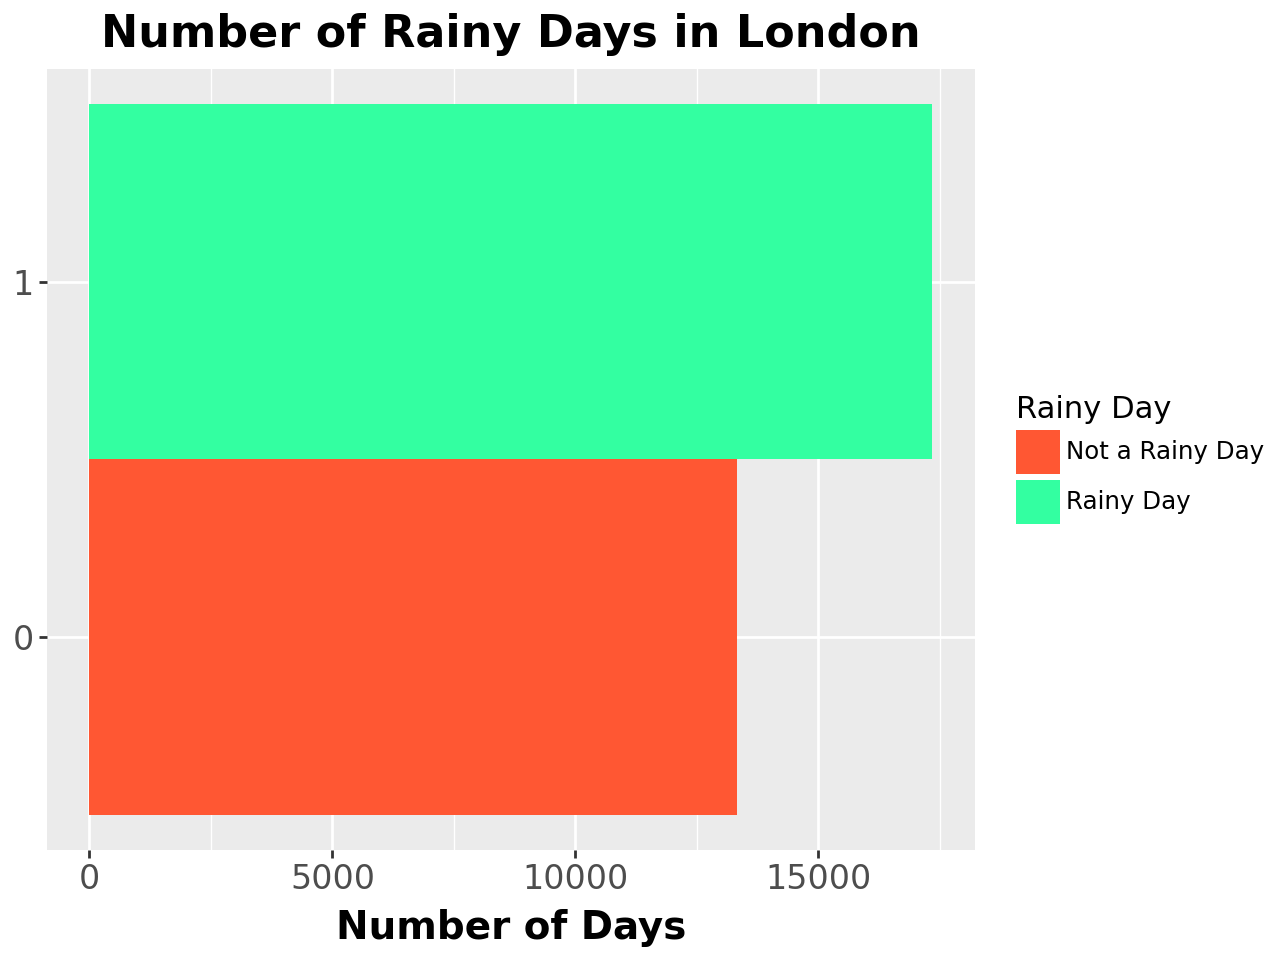

In [20]:
london_rainy_days_df = london_weather_df.loc[:, ['date', 'precipitation_hours']]
london_rainy_days_df['rainy_day'] = (london_rainy_days_df['precipitation_hours'] > 0).astype(int)
london_rainy_days_df = london_rainy_days_df[['date', 'rainy_day']]

# Calculate the count of rainy and non-rainy days
rainy_day_counts = london_rainy_days_df['rainy_day'].value_counts().reset_index()

# Rename columns for clarity
rainy_day_counts.columns = ['rainy_day', 'count']

# Create the pie chart using Plotnine
number_rainy_days_london = (ggplot(rainy_day_counts, aes(x='factor(rainy_day)', y='count', fill='factor(rainy_day)')) +
             geom_bar(stat='identity', width=1) +
             coord_flip() +
             scale_fill_manual(values=["#FF5733", "#33FFA1"], labels=["Not a Rainy Day", "Rainy Day"]) +  
             labs(title='Number of Rainy Days in London',
                  fill='Rainy Day',
                  x='', y='Number of Days') +
             theme(axis_text_x=element_text(size=12),
                   axis_text_y=element_text(size=12),
                   axis_title=element_text(size=14, weight='bold'),
                   plot_title=element_text(size=16, weight='bold'))
            )

# Display the pie chart
print(number_rainy_days_london)

/var/folders/6w/w0l0jj416lb8x18v4b5chr800000gn/T/ipykernel_70426/217513700.py:28: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


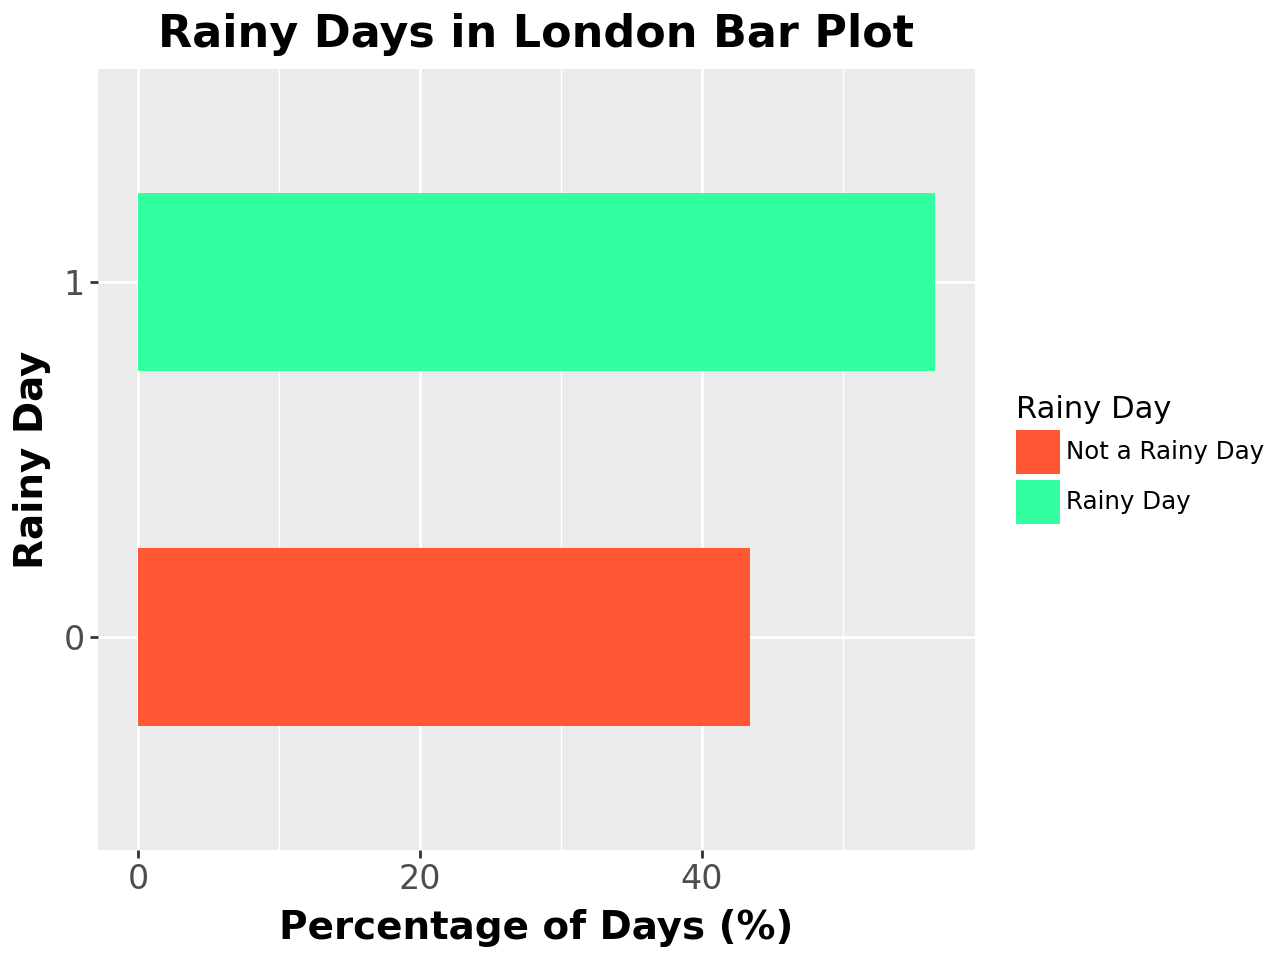

In [21]:
london_rainy_days_df = london_weather_df.loc[:, ['date', 'precipitation_hours']]
london_rainy_days_df['rainy_day'] = (london_rainy_days_df['precipitation_hours'] > 0).astype(int)
london_rainy_days_df = london_rainy_days_df[['date', 'rainy_day']]

# Calculate the count of rainy and non-rainy days
rainy_day_counts = london_rainy_days_df['rainy_day'].value_counts(normalize=True) * 100
rainy_day_counts = rainy_day_counts.reset_index()

# Rename columns for clarity
rainy_day_counts.columns = ['rainy_day', 'percentage']

# Create the bar plot using Plotnine
bar_plot = (ggplot(rainy_day_counts, aes(x='factor(rainy_day)', y='percentage', fill='factor(rainy_day)')) +
            geom_bar(stat='identity', width=0.5) +
            coord_flip() +
            scale_fill_manual(values=["#FF5733", "#33FFA1"], labels=["Not a Rainy Day", "Rainy Day"]) +  
            labs(title='Rainy Days in London Bar Plot',
                 fill='Rainy Day',
                 x='Rainy Day',
                 y='Percentage of Days (%)') +
            theme(axis_text_x=element_text(size=12),
                  axis_text_y=element_text(size=12),
                  axis_title=element_text(size=14, weight='bold'),
                  plot_title=element_text(size=16, weight='bold'))
           )

# Display the bar plot
print(bar_plot)